# Natural Language Processing

The entire notebook is built upon [Chapter 3](https://web.stanford.edu/~jurafsky/slp3/3.pdf) of Jurafsky and Martin, Speech and Language Processing, 3rd edition. Please read chapter 3 before proceeding to this lab, the pdf is included in the week03 folder. Instead of giving theoratical guidance, this lab will be mainly focus on implementations and examples. Understanding this lab is an important step torwards underestanding the framework of Large Language Models.

## 0. Learning goals

1. **Build** unigram/bi-/tri-gram language models (LMs) from scratch with NLTK.
2. **Estimate** MLE probabilities and apply Laplace (add-1) and add-*k* smoothing (§ 3.6.1–3.6.2).
3. **Combine** n-gram orders with linear interpolation (Eq. 3.29).
4. **Evaluate** models with *per-token perplexity* (Eq. 3.15–3.17).
5. **Sample** sentences to “see” what an LM has learned (§ 3.4).
6. **Reason** about why smoothing balances *memorisation vs. generalisation* (§ 3.6).


Please first make sure that you have installed nltk
```bash
pip install nltk
python -m nltk.downloader brown punkt
```

In [ ]:
import random, math
import nltk
from matplotlib import pyplot as plt
from nltk.corpus import brown
from nltk import FreqDist
from nltk.lm import MLE, Laplace, Vocabulary
from nltk.lm.models import KneserNeyInterpolated, WittenBellInterpolated
import numpy as np
from nltk import bigrams
from nltk.lm.preprocessing import padded_everygram_pipeline, pad_both_ends, pad_sequence
from nltk.util import ngrams
import math


## 2. Corpus exploration (20 min)

1. Load **Brown** genre *news* (≈24 k sentences).
2. Tokenise → lowercase → strip punctuation.
3. Show

   * top-20 unigrams (`FreqDist`)
   * sentence-length histogram (`plt.hist`)

[nltk_data] Downloading package brown to /home/tagore/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/tagore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 20 unigrams:
the: 6386
of: 2861
and: 2186
to: 2144
a: 2130
in: 2020
for: 969
that: 829
is: 733
was: 717
on: 691
he: 642
at: 636
with: 567
be: 526
as: 517
by: 504
it: 478
his: 428
said: 406


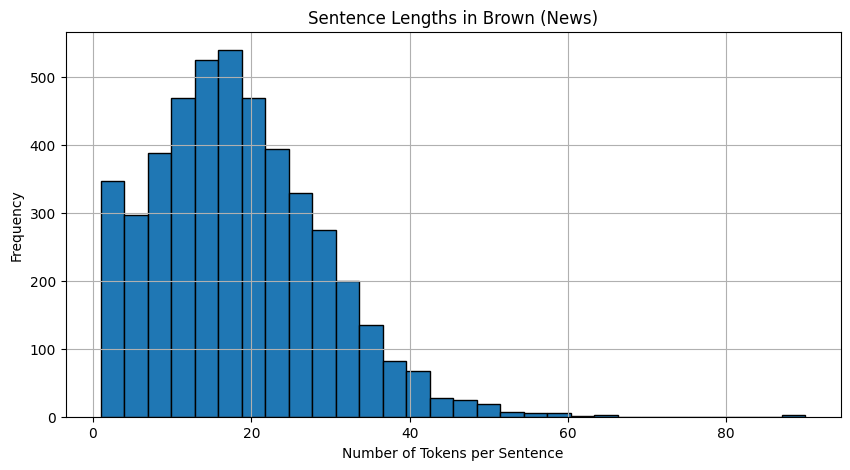

In [2]:
nltk.download('brown')
nltk.download('punkt')

# 1. Load Brown corpus with genre='news'
news_sents = brown.sents(categories='news')

# 2. Tokenize, lowercase, and strip punctuation
def preprocess_sentence(sent):
    return [
        word.lower() for word in sent
        if word.isalpha()  # strips punctuation
    ]

cleaned_sents = [preprocess_sentence(sent) for sent in news_sents]

# Flatten into one list of words for FreqDist
all_words = [word for sent in cleaned_sents for word in sent]

# 3a. Show top-20 unigrams
fdist = FreqDist(all_words)
print("Top 20 unigrams:")
for word, freq in fdist.most_common(20):
    print(f"{word}: {freq}")

# 3b. Plot sentence length histogram
sent_lengths = [len(sent) for sent in cleaned_sents if len(sent) > 0]

plt.figure(figsize=(10, 5))
plt.hist(sent_lengths, bins=30, edgecolor='black')
plt.title("Sentence Lengths in Brown (News)")
plt.xlabel("Number of Tokens per Sentence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

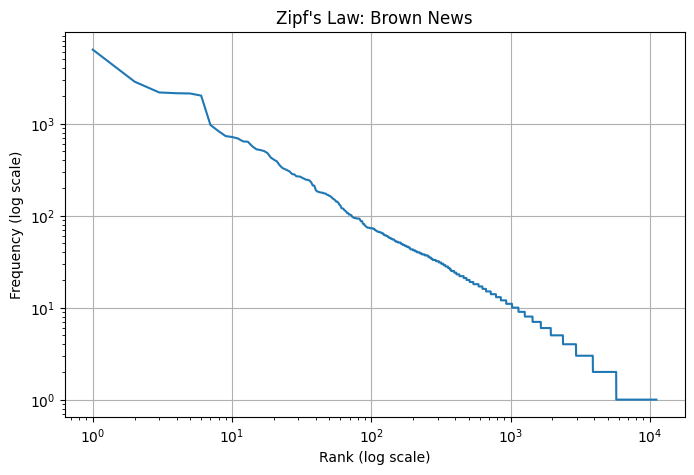

In [3]:
# Zipf's Law: log-rank vs log-frequency
freqs = [freq for word, freq in fdist.most_common()]
ranks = np.arange(1, len(freqs) + 1)

plt.figure(figsize=(8, 5))
plt.loglog(ranks, freqs)
plt.title("Zipf's Law: Brown News")
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.grid(True)
plt.show()


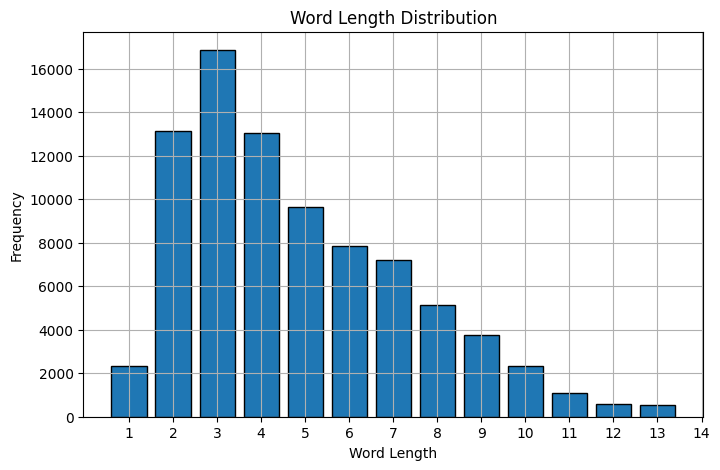

In [4]:
word_lengths = [len(word) for word in all_words]

plt.figure(figsize=(8, 5))
plt.hist(word_lengths, bins=range(1, 15), align='left', rwidth=0.8, edgecolor='black')
plt.title("Word Length Distribution")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.xticks(range(1, 15))
plt.grid(True)
plt.show()

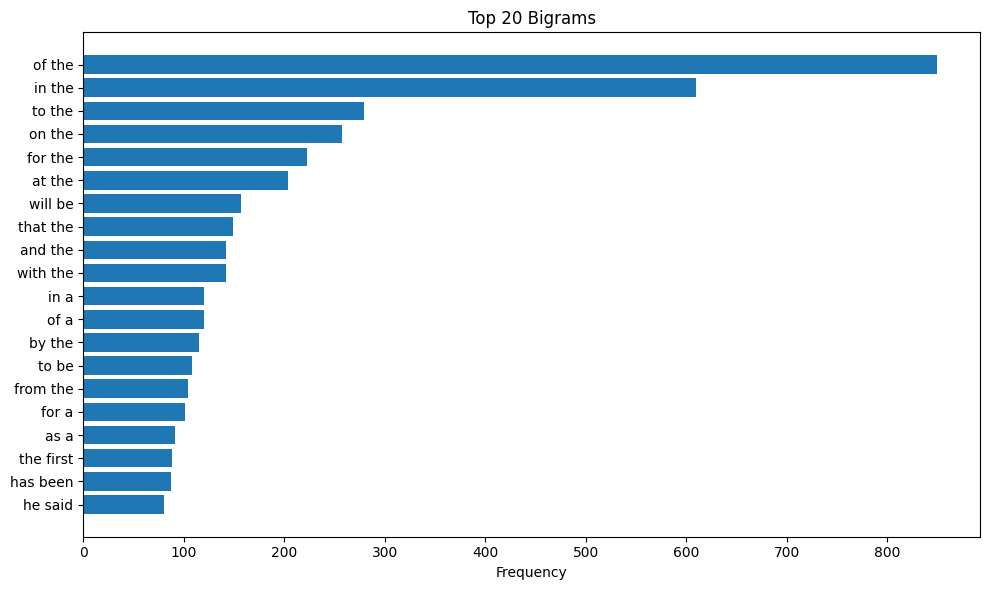

In [ ]:
bigram_freq = FreqDist(bigrams(all_words))
top_bigrams = bigram_freq.most_common(20)

# Bar chart
labels = [' '.join(pair) for pair, _ in top_bigrams]
counts = [count for _, count in top_bigrams]

plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], counts[::-1])  # Reverse to show highest at top
plt.title("Top 20 Bigrams")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


## 3. Build baseline n-gram LMs (40 min)

```python
n = 3
train, vocab = padded_everygram_pipeline(n, brown.sents(categories='news'))
mle = MLE(n); mle.fit(*train, vocabulary_text=vocab)
```

* Inspect raw counts: `mle.counts[('the',)]['dog']`.
* Compute sentence probability via chain rule (Eq. 3.11, students derive).
* Implement `sentence_perplexity(model, sent)` using Eq. 3.15.

Checkpoint: list perplexities for **uni/bigram/trigram** on a held-out dev set. Students should notice the classic drop 962 → 170 → 109 in WSJ example § 3.2 (table).

---

In [28]:
import math, nltk
from nltk.corpus import brown
from nltk.lm import Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline, pad_sequence
from nltk.util import ngrams

nltk.download("brown")

# ----------------------------------------------------------------------
# 1. Pre-process Brown → lowercase words, strip punctuation
def preprocess_brown(category="news"):
    for sent in brown.sents(categories=category):
        yield [w.lower() for w in sent if w.isalpha()]

corpus_sents = list(preprocess_brown("news"))          # reuse in all steps

# ----------------------------------------------------------------------
# 2. Build Laplace-smoothed n-gram LM; return (model, vocab_set)
def train_lm(order, sentences):
    train_ngrams, padded_sents = padded_everygram_pipeline(order, sentences)
    padded_sents = list(padded_sents)                  # materialise once
    vocab_tokens = [tok for sent in padded_sents for tok in sent]
    model = Laplace(order)
    model.fit(train_ngrams, vocabulary_text=vocab_tokens)
    return model, set(vocab_tokens)

mle1, vocab = train_lm(1, corpus_sents)                # same vocab for all
mle2, _      = train_lm(2, corpus_sents)
mle3, _      = train_lm(3, corpus_sents)

# ----------------------------------------------------------------------
# Bigram example
print("Bigram ('the','president') count :",
      mle2.counts[('the',)]['president'])

# Trigram example
print("Trigram ('the','united','states') count :",
      mle3.counts[('the','united')]['states'])


# ----------------------------------------------------------------------
# 4. Utilities ----------------------------------------------------------
def sentence_perplexity(model, sent):
    n = model.order
    padded = pad_sequence(sent, n,
                          pad_left=True, left_pad_symbol="<s>",
                          pad_right=True, right_pad_symbol="</s>")
    logprob, N = 0.0, 0
    for ng in ngrams(padded, n):
        context, token = ng[:-1], ng[-1]
        p = model.score(token, context)
        logprob += math.log(p)          # Laplace ⇒ p>0 always
        N += 1
    return math.exp(-logprob / N)

def avg_pp(model, dev):
    if not dev:
        return float("nan")
    vals = [sentence_perplexity(model, s) for s in dev]
    return sum(vals) / len(vals)

# ----------------------------------------------------------------------
# 5. Build dev set (last 170 sentences) with *true* OOV filtering
dev_raw   = corpus_sents[-170:]
dev_clean = [[w for w in sent if w in vocab] for sent in dev_raw]
dev_clean = [s for s in dev_clean if s]                # drop empties

# ----------------------------------------------------------------------
# 6. Evaluate
print("\nPerplexities on held-out dev set")
for name, model in [("Unigram", mle1), ("Bigram", mle2), ("Trigram", mle3)]:
    pp = avg_pp(model, dev_clean)
    print(f"{name:8}: {pp:.1f}")


[nltk_data] Downloading package brown to /home/tagore/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Bigram ('the','president') count : 0
Trigram ('the','united','states') count : 0

Perplexities on held-out dev set
Unigram : 47.1
Bigram  : 17.2
Trigram : 11.1


Below is a complete **hands-on lab (≈ 3 h in class + optional homework)** that stays *squarely* inside the Chapter 3 toolkit—n-grams, smoothing, perplexity, sampling—so students master the classical ideas *before* they ever hear the word *Transformer*.

---

## 0. Learning goals

1. **Build** unigram/bi-/tri-gram language models (LMs) from scratch with NLTK.
2. **Estimate** MLE probabilities and apply Laplace (add-1) and add-*k* smoothing (§ 3.6.1–3.6.2).
3. **Combine** n-gram orders with linear interpolation (Eq. 3.29).
4. **Evaluate** models with *per-token perplexity* (Eq. 3.15–3.17).
5. **Sample** sentences to “see” what an LM has learned (§ 3.4).
6. **Reason** about why smoothing balances *memorisation vs. generalisation* (§ 3.6).

---

## 1. Setup (15 min)

```bash
pip install nltk   # classic toolkit
python -m nltk.downloader brown punkt
```

Starter notebook header:

```python
import random, math
from nltk.corpus import brown
from nltk import FreqDist
from nltk.lm import MLE, Laplace, Vocabulary, InterpolatedLanguageModel
from nltk.lm.preprocessing import padded_everygram_pipeline
```

---

## 2. Corpus exploration (20 min)

1. Load **Brown** genre *news* (≈24 k sentences).
2. Tokenise → lowercase → strip punctuation.
3. Show

   * top-20 unigrams (`FreqDist`)
   * sentence-length histogram (`plt.hist`)

### Discussion prompt

*“Eq. 3.1–3.2 tell us we want P(next word | history). Why might long sentences make that harder?”*

---

## 3. Build baseline n-gram LMs (40 min)

```python
n = 3
train, vocab = padded_everygram_pipeline(n, brown.sents(categories='news'))
mle = MLE(n); mle.fit(*train, vocabulary_text=vocab)
```

* Inspect raw counts: `mle.counts['the']['dog']`.
* Compute sentence probability via chain rule (Eq. 3.11, students derive).
* Implement `sentence_perplexity(model, sent)` using Eq. 3.15.

Checkpoint: list perplexities for **uni/bigram/trigram** on a held-out dev set. Students should notice the classic drop 962 → 170 → 109 in WSJ example § 3.2 (table).

---

## 4. Smoothing & add-*k* sweep (35 min)

1. **Laplace** (`Laplace(n)`) – verify Eq. 3.24/3.26 on a single bigram.
2. **add-k**: loop over *k* ∈ {0.05, 0.1, 0.5} and plot dev-set perplexity.
3. Visualise *discount* d = new / old count for a few bigrams (Fig. 3.8 inspiration).

### Reflection

“Why does add-1 often *hurt* train perplexity but help test perplexity?” (over-allocation of mass to zeros ).

---

## 5. Interpolation (25 min)

```python
from nltk.lm.interpolated import SimpleInterpolatedLM
lambdas = [0.2, 0.3, 0.5]   # must sum to 1
interp = SimpleInterpolatedLM(order_weights=lambdas, estimators=(MLE, MLE, MLE))
interp.fit(*train, vocabulary_text=vocab)
```

* Tune λ on dev set (grid or simple EM).
* Compare perplexity curve: trigram-MLE vs. interpolated LM.

---

## 6. Sentence sampling (15 min)

```python
def sample(model, max_len=20, seed=['<s>']):
    out = seed.copy()
    for _ in range(max_len):
        nxt = model.generate(text_seed=out)
        if nxt == '</s>': break
        out.append(nxt)
    return ' '.join(out[1:])
```

Students generate 5 sentences each from unigram, bigram, trigram; mark as *OK / odd / nonsense*.

---

## 7. Mini-challenge (30 min)

Teams choose one:

* **Stupid backoff** S(w|h) (Eq. 3.31, α = 0.4).
* **Kneser-Ney** via `nltk.lm.KneserNeyInterpolated`.
* **Good-Turing** counts manually (advanced).

Goal: beat baseline dev perplexity; post results on classroom board.

---

## 8. Deliverables

* Notebook with:

  * Table of train/dev perplexities for each model & smoothing choice.
  * 3 sampled sentences per model with brief commentary.
  * ≤ 250-word reflection: **“How does smoothing combat the zero-probability problem and what trade-off does it create?”**
* Optional HW: implement held-out tuning of λ via EM (Eq. 3.30).

---

### Why this progression works

* Follows Chapter 3 order—n-grams → smoothing → perplexity → sampling—so every code cell is grounded in the same equations the book just introduced.
* Students *see* Laplace’s effect on counts and perplexity, connecting theory to practice.
* Interpolation demo shows how combining evidence from different-order contexts solves data sparsity—key intuition they’ll reuse when neural LMs appear later.

With this lab under their belt, the class will be fully fluent in “classic” language modelling and ready for neural extensions when the time is right.
